# Import modules

In [1]:
import xarray as xr
import numpy as np
import cftime
import matplotlib as mpl
import matplotlib.pyplot as plt
import seaborn as sns
import pandas as pd
from itertools import cycle
import functools
from matplotlib import animation
from textwrap import wrap

# Functions

In [2]:
def sizedist(group_name, group_type, bins, wet_radius, numdensity): 
    bin_str = [ str(int(n)) if n > 9 else "0"+str(int(n)) for n in bins]
    
    if group_type == 'standard':        
        reff_tmp = []
        dist_tmp = []
        for bn in bin_str:
            reff_tmp.append(wet_radius[group_name + bn + 'WR']) 
            dist_tmp.append(numdensity[group_name + bn + 'ND'])
        reff = xr.concat(reff_tmp, dim='bin').assign_coords({"bin": bins}).assign_attrs(units=wet_radius[group_name + bn + 'WR'].units, description='Bin radius')
        dist = xr.concat(dist_tmp, dim='bin').assign_coords({"bin": bins})
        
        dr = np.zeros(np.shape(reff))
        dr[0, :] = reff.sel(bin=bins[1]).values - reff.sel(bin=bins[0]).values
        dr[-1, :] = reff.sel(bin=bins[-1]).values - reff.sel( bin=bins[-2]).values
        # dr[0, :] = (reff.sel(bin=bins[1]).values - reff.sel(bin=bins[0]).values) * reff.sel(bin=bins[0]).values/reff.sel(bin=bins[1]).values
        # dr[-1, :] = (reff.sel(bin=bins[-1]).values - reff.sel( bin=bins[-2]).values)  * reff.sel(bin=bins[-2]).values/reff.sel(bin=bins[-1]).values

        for b, bn in enumerate(bins[1:-1]):
            b +=1
            vp = reff.sel(bin=bins[b+1]).values
            vm = reff.sel(bin=bins[b-1]).values
            v0 = reff.sel(bin=bins[b]).values
            dr[b, :] = np.sqrt(vp*v0) - np.sqrt(vm*v0)
        dreff = xr.DataArray(data=dr, name='dr', coords=reff.coords, dims=reff.dims)
        
        dist = dist/dreff*reff
        dist = dist.assign_attrs(long_name='Aerosol size distribution', units= "#/cm3", description='dN/dlogr')

    
    elif group_type == 'fractal':
        dist_tmp = []
        for bn in bin_str:
            dist_tmp.append(numdensity[group_name + bn + 'ND'])
            
        tmp = xr.concat(dist_tmp, dim='bin').assign_coords({"bin": bins})   
        tmp = tmp/ tmp.sum('bin')
        dist = tmp.assign_attrs(long_name="Fraction of agglomerates", units='', description='Fraction')


    return dist


# Definitions

In [3]:
in_dir = "../../run/carma/"
plot_dir = "../../tests/python/figures/"

# List of names of the experiments
exper_list = ['sulftest'] 
exper_spec = {'sulftest': 'sulfatetest_test.nc'}  
# exper_list = ['alum-215nm'] 
# exper_spec = {'alum-215nm': 'alumina-215nm_test.nc'}

# Name of the file corresponding to name of the experiment 
# All the experiment need to have the same number and type of gases, elements, groups

gases = ['Q', 'H2SO4']
elements = ['SULF']
groups = ['PRSUL']
group_types = {'PRSUL' : 'standard'}

# gases = ['']
# elements = ['ALUM']
# groups = ['PRALUM']
# group_types = {'PRALUM' : 'fractal'}

# Dictionary

In [4]:
ds = dict()

for exp in exper_list:
    ds[exp] = xr.open_dataset(in_dir + exper_spec[exp], decode_times=False)


# Plots

In [5]:
# Atm variables
atm_vars = ['P', 'Z', 'RHOA',  'T', 'deltaT', 'RLHEAT']

# Gas variables
gases_vars = ['', 'SL', 'SI', 'EI', 'EL', 'WT']

# Gas variables
elements_vars = ['MR']

# Group variables
bin_vars = ['r', 'rlow', 'rup', 'dr', 'arat', 'rrat', 'rprat', 'rmass', 'dm', 'vol', 'df','nmon']
groups_vars = [ 'ND',  'MR', 'MD', 'RE', 'RM', 'AD', 'PA', 'AR', 'VM', 'JN', 'EX_VIS', 'OD_VIS' ]
groupbins_vars = [ 'ND', 'RO', 'MR']

In [6]:
color_exp = { exp: sns.color_palette()[e] for e, exp in enumerate(exper_list) } 

tmp_list = [grp+exp  for grp in groups for exp in exper_list]
color_grp = { exp: sns.color_palette()[e] for e, exp in enumerate(tmp_list) } 

line_exp = { exp: '-' for e, exp in enumerate(exper_list) } 

linestyle_str = ['solid', 'dotted', 'dashed','dashdot']

## Atm

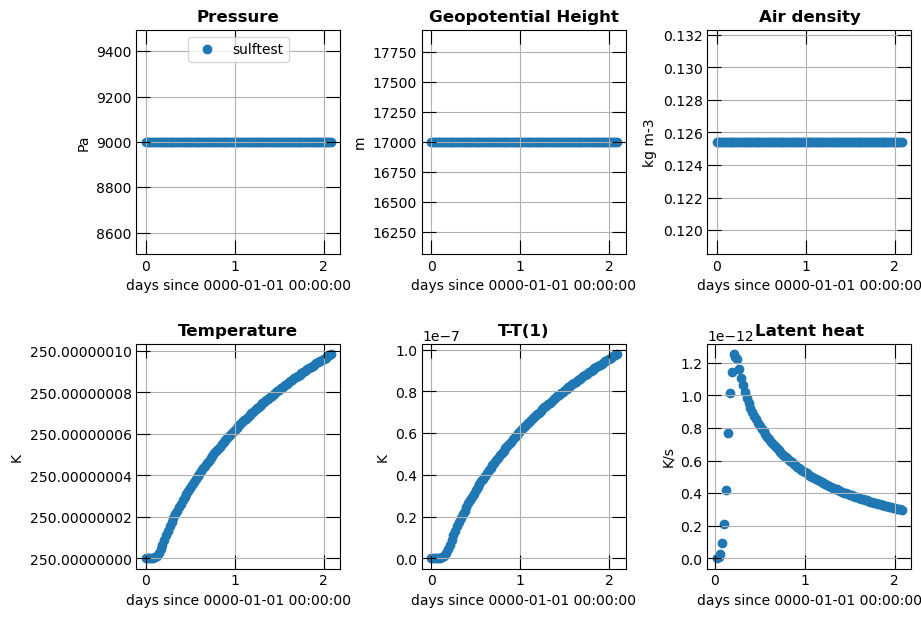

In [7]:
fig, axs = plt.subplots(figsize=(10, 7), nrows=2, ncols=int(len(atm_vars)/2)) 
axs = axs.flatten()

fig.subplots_adjust(hspace=0.4, wspace=0.4)

for i, var in enumerate(atm_vars):
    for exp in exper_list:
        if var in ds[exp].keys():       
            axs[i].scatter(ds[exp].time, ds[exp][var], linestyle=line_exp[exp],  color=color_exp[exp], label=exp)
            axs[i].set_title(ds[exp][var].long_name, fontweight='bold') 
            axs[i].set_ylabel(ds[exp][var].units)

        ## Axis aspect 
        axs[i].grid()
        axs[i].tick_params( direction="in", length=10, top=True, right=True)
        axs[i].set_xlabel(ds[exp].time.units)
        axs[i].get_yaxis().get_major_formatter().set_useOffset(False)


axs[0].legend( loc='upper center', fancybox=True)

fig.patch.set_facecolor('white')
#fig.savefig(plot_dir +'atm.png', bbox_inches='tight')

## Gases

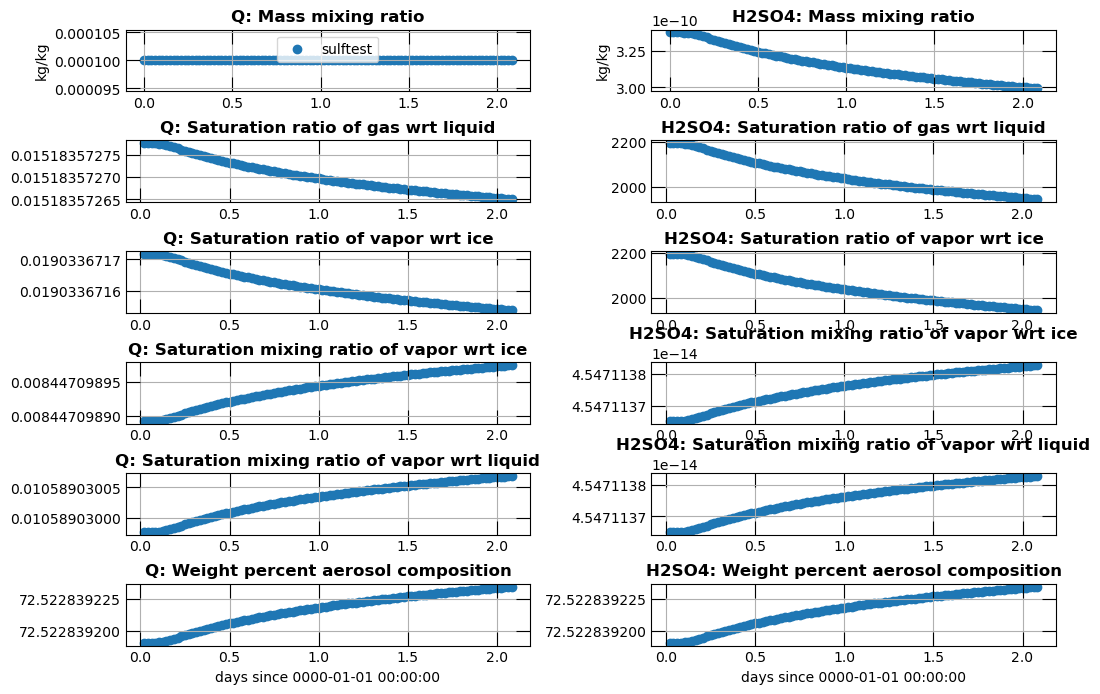

In [8]:
fig, axs = plt.subplots(figsize=( 12, 8), nrows=len(gases_vars), ncols=len(gases)) 
axs = axs.flatten()

fig.subplots_adjust(hspace=0.8, wspace=0.3)

for g, gas in enumerate(gases):
    for v, var in enumerate(gases_vars):
        varname = gas + var
        i = len(gases) * v + g
        for exp in exper_list:
            if varname in ds[exp].keys(): 
                axs[i].scatter(ds[exp].time, ds[exp][varname], linestyle=line_exp[exp],  color=color_exp[exp], label=exp)
                axs[i].set_ylabel(ds[exp][varname].units)
                axs[i].set_title(gas + ': ' + ds[exp][varname].long_name, fontweight='bold')    
        
        ## Axis aspect      
        axs[i].grid()
        axs[i].tick_params( direction="in", length=10, top=True, right=True)
        axs[i].get_yaxis().get_major_formatter().set_useOffset(False)

[ axs[i].set_xlabel(ds[exp].time.units) for i in [-2,-1]]
axs[0].legend( loc='upper center', fancybox=True)

fig.patch.set_facecolor('white')
fig.savefig(plot_dir +'gases.png', bbox_inches='tight')

## Groups

### Bins

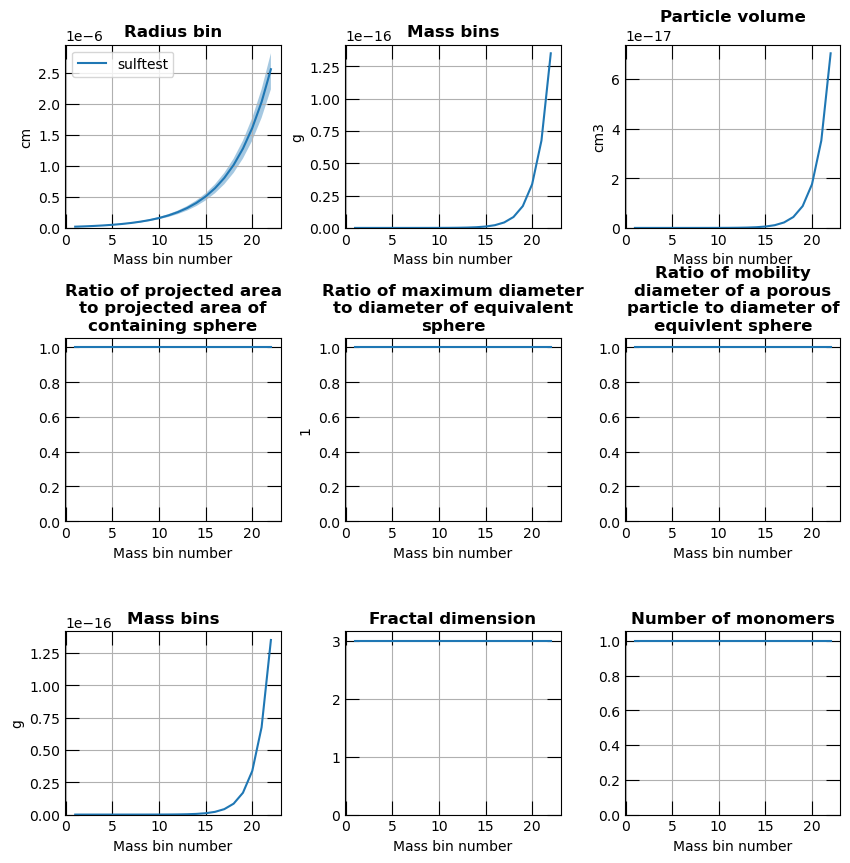

In [9]:
fig, axs = plt.subplots(figsize=(10, 10), nrows=3, ncols=3)  
axs = axs.flatten()
fig.subplots_adjust(hspace=0.6, wspace=0.3)

                
for v, var in enumerate(['r', 'rmass', 'vol', 'arat', 'rrat', 'rprat', 'rmass', 'df', 'nmon']):
    for g, grp in enumerate(groups):
        varname = grp + '_' + var
        i = len(groups) * v + g
        for exp in exper_list:
            if varname in ds[exp].keys(): 
                axs[i].plot(ds[exp].bin, ds[exp][varname], label=exp)    
                if var == 'r':
                    axs[i].fill_between(ds[exp].bin, ds[exp][grp + '_rup'], ds[exp][grp + '_rlow'], alpha=0.4)
        
        ## Axis aspect
        axs[i].set_title( "\n".join(wrap(ds[exp][varname].long_name, 25)), fontweight='bold')
        axs[i].set_ylabel(ds[exp][varname].units)    
        axs[i].set_xlabel('Mass bin number')
        axs[i].grid()
        axs[i].tick_params( direction="in", length=10, top=True, right=True)
        axs[i].set_ylim(bottom=0)
        axs[i].ticklabel_format(style='sci', scilimits=(-4,4), axis='y')


axs[0].legend( fancybox=True)

fig.patch.set_facecolor('white')
# fig.savefig(plot_dir +'bins.png', bbox_inches='tight')

### Group variables timeseries

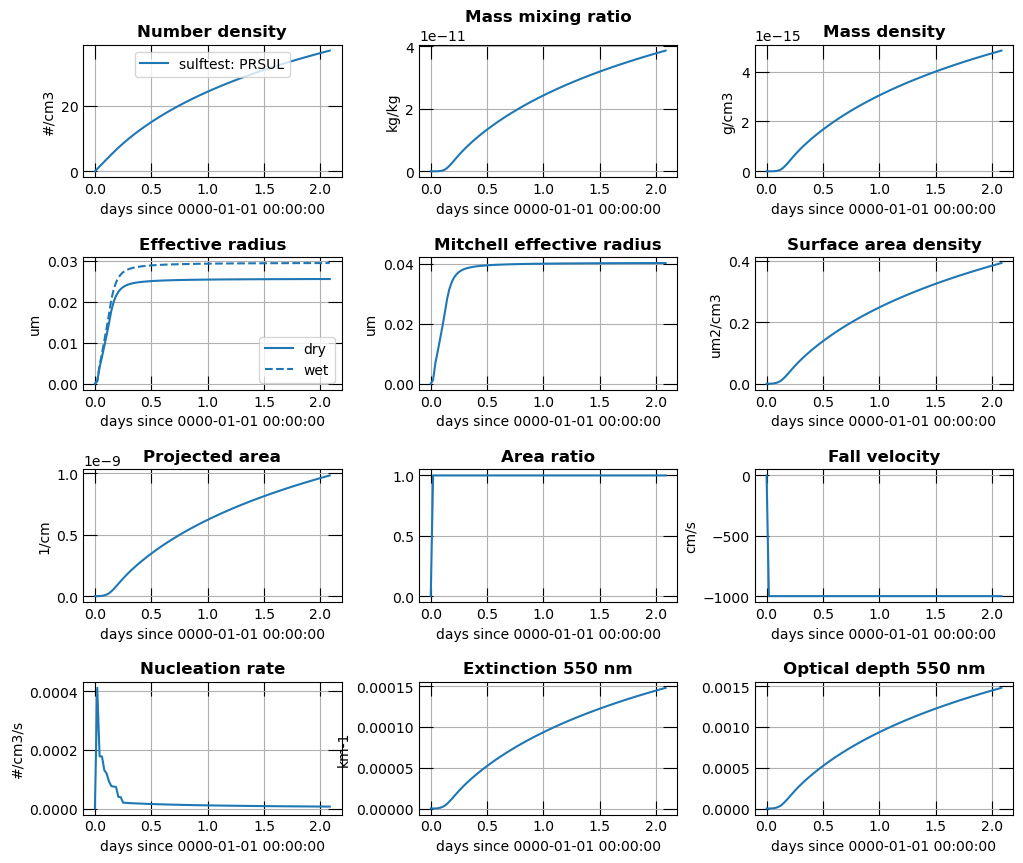

In [10]:
fig, axs = plt.subplots(figsize=(12, 10), nrows=4, ncols=3) 
axs = axs.flatten()

fig.subplots_adjust(hspace=0.6, wspace=0.3)

for i, var in enumerate(groups_vars):
    for g, grp in enumerate(groups):
        varname = grp + var
        for e, exp in enumerate(exper_list):
            
            if varname in ds[exp].keys():
                axs[i].set_title(ds[exp][varname].long_name, fontweight='bold') 
                axs[i].plot(ds[exp].time, ds[exp][varname], linestyle=line_exp[exp], color=color_grp[grp+exp], label=exp +': ' + grp)
                axs[i].set_ylabel(ds[exp][varname].units)
                if var == 'RE':
                    axs[i].plot(ds[exp].time, ds[exp][grp + 'REw'], linestyle='--',  color=color_grp[grp+exp])
                    axs[i].set_title( 'Effective radius', fontweight='bold') 
                    axs[i].legend(['dry', 'wet'])
        
        ## Axis aspect 
        axs[i].grid()
        axs[i].tick_params( direction="in", length=10, top=True, right=True)
        axs[i].set_xlabel(ds[exp].time.units)


[axs[j].axis('off') for j in range(i+1, len(axs))]

axs[0].legend( loc='upper center',  fancybox=True)
fig.patch.set_facecolor('white')
fig.savefig(plot_dir +'groups.png', bbox_inches='tight')

### Size distributions

In [11]:
for grp in groups:
    for exp in exper_list:
        my_list = list(ds[exp].keys())
        wr_list = [item for item in my_list if 'WR' in item]
        nd_list = [item for item in my_list if 'ND' in item]
        wet_radius = ds[exp][wr_list]
        numdensity = ds[exp][nd_list]
        
    
        ds[exp][grp + 'dist'] = sizedist(grp, group_types[grp], ds[exp].bin, wet_radius, numdensity)


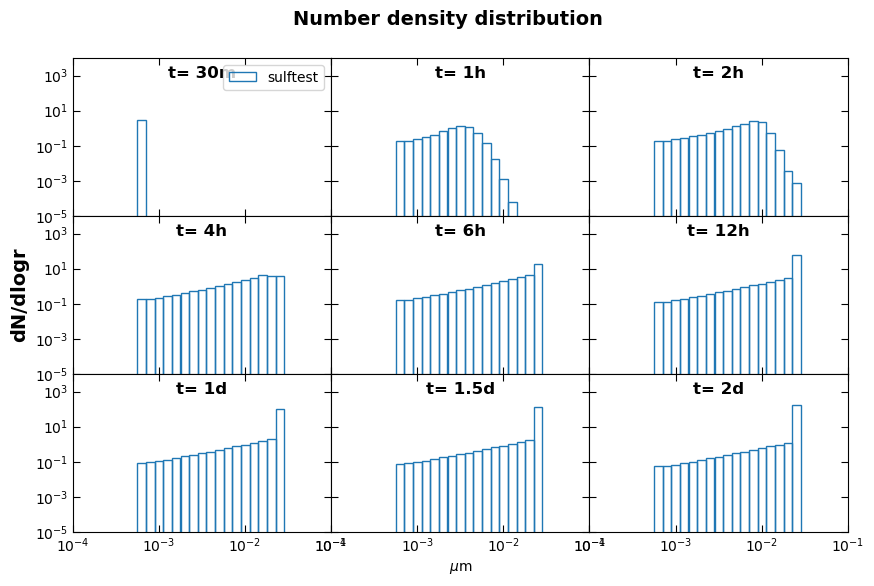

In [12]:
fig, axs = plt.subplots(figsize=(10, 6), nrows=3, ncols=3) 
axs = axs.flatten()    
fig.subplots_adjust(top=0.9, hspace=0., wspace=0.)


tt = [ 1, 2,  4, 8, 12, 24, 48, 60, 96]
ttt = ['30m', '1h','2h', '4h', '6h', '12h', '1d', '1.5d', '2d']

for i, t in enumerate(tt):
    for exp in exper_list:
        for grp in groups:
            
            vr = ds[exp][grp + 'dist'].sel(time = ds[exp].time[t])

            if group_types[grp] == 'standard':
                axs[i].bar( ds[exp][grp + '_r'].values * 1e4, vr.values, 
                   align='center', width=ds[exp][grp + '_dr'].values * 1e4, 
                   edgecolor=color_grp[grp+exp], color='none', label=exp)
                    
                axs[i].set(xscale='log', yscale='log', xticks=[1e-4, 1e-3, 1e-2, 1e-1, 1], xlim=[1e-4, 1e-1], ylim=[1e-5, 1e4])

           
            elif group_types[grp] == 'fractal':
                axs[i].bar( ds[exp]['bin'], vr.values, 
                    align='center', width=1, edgecolor=color_exp[exp], color='none', label=exp)

                axs[i].set( xticks=ds[exp]['bin'], yticks=np.arange(0.0, 1., 0.2), xlim=[0., len(ds[exp]['bin'])+1], ylim=[0, 1.04])

     # Axis aspect
    axs[i].set_title( 't= ' + ttt[i], y=0.82, fontweight='bold')
    axs[i].minorticks_on()
    axs[i].tick_params(which='major',direction="in", length=5, top=True, right=True)
    axs[i].tick_params(which='minor', direction="in", length=2.5, top=False, bottom=False, right=True, left=True)
    
    if i < 6:
        axs[i].set_xticklabels([])

    if i%3:
        axs[i].set_yticklabels([])

axs[0].legend()

if group_types[grp] == 'standard':
    plt.suptitle( 'Number density distribution', fontweight='bold', fontsize=14)
    axs[3].set_ylabel("dN/dlogr", fontweight='bold', fontsize=14 )
    axs[-2].set_xlabel(r'$\mu$m')
elif group_types[grp] == 'fractal':
    plt.suptitle('Number density fraction per agglomerate', fontweight='bold', fontsize=16)
    axs[3].set_ylabel(ds[exp][grp + 'dist'].description)
    axs[-2].set_xlabel(r'Bin')



fig.patch.set_facecolor('white')
fig.savefig(plot_dir +'NDdist.png', bbox_inches='tight')

## Elements

In [13]:
def massfrct(group_name, element_name, bins, group_mmr, element_mmr): 
    bin_str = [ str(int(n)) if n > 9 else "0"+str(int(n)) for n in bins]
    
    elm_tmp = []
    grp_tmp = []
    for bn in bin_str:
        elm_tmp.append(element_mmr[element_name + bn + 'MR'])
        grp_tmp.append(group_mmr[group_name + bn + 'MR'])
        
    elm_xr = xr.concat(elm_tmp, dim='bin').assign_coords({"bin": bins})   
    grp_xr = xr.concat(elm_tmp, dim='bin').assign_coords({"bin": bins})   
    dist = elm_xr/grp_xr
    dist = dist.assign_attrs(long_name="Mass fraction", units='', description='Fraction')


    return dist

In [14]:
grp = groups[0]

for exp in exper_list:
    for elm in elements:    
        my_list = list(ds[exp].keys())
        mmr_list = [item for item in my_list if 'MR' in item]
        elm_list = [item for item in mmr_list if elm in item]
        grp_list = [item for item in mmr_list if grp in item]
        elm_mmr = ds[exp][elm_list]
        grp_mmr = ds[exp][grp_list]
        
    
        ds[exp][elm + 'massfrac'] = massfrct(grp, elm, ds[exp]['bin'], grp_mmr, elm_mmr)


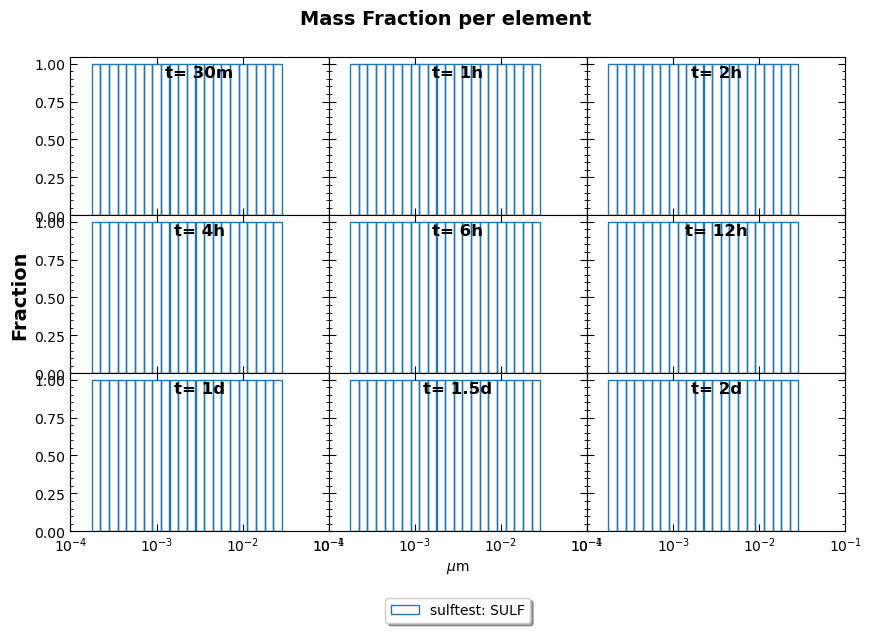

In [15]:
fig, axs = plt.subplots(figsize=(10, 6), nrows=3, ncols=3) 
axs = axs.flatten()    
fig.subplots_adjust(top=0.9, hspace=0., wspace=0.)


tt = [ 1, 2,  4, 8, 12, 24, 48, 60, 96]
ttt = ['30m', '1h','2h', '4h', '6h', '12h', '1d', '1.5d', '2d']

for i, t in enumerate(tt):
    for exp in exper_list:
        for elm in elements:
        
            vr = ds[exp][elm + 'massfrac'].sel(time = ds[exp].time[t])

            if group_types[grp] == 'standard':
                    axs[i].bar( ds[exp][grp + '_r'].values * 1e4, vr.values, 
                       align='center', width=ds[exp][grp + '_dr'].values * 1e4, 
                       edgecolor=color_grp[grp+exp], color='none', label=exp + ': ' + elm)
    
                        
                    axs[i].set(xscale='log', xticks=[1e-4, 1e-3, 1e-2, 1e-1, 1], xlim=[1e-4, 1e-1], ylim=[0, 1.04])
                    
               
            elif group_types[grp] == 'fractal':
                    axs[i].bar( ds[exp]['bin'], vr.values, 
                        align='center', width=1, edgecolor=color_exp[exp], color='none', label=exp + ': ' + elm)
    
                    axs[i].set( xticks=ds[exp]['bin'], yticks=np.arange(0.0, 1., 0.2), xlim=[0., len(ds[exp]['bin'])+1], ylim=[0, 1.04])
                   
           
     # Axis aspect
    axs[i].set_title( 't= ' + ttt[i], y=0.82, fontweight='bold')
    axs[i].minorticks_on()
    axs[i].tick_params(which='major',direction="in", length=5, top=True, right=True)
    axs[i].tick_params(which='minor', direction="in", length=2.5, top=False, bottom=False, right=True, left=True)
    
    if i < 6:
        axs[i].set_xticklabels([])

    if i%3:
        axs[i].set_yticklabels([])
        

axs[-2].legend(loc='center', bbox_to_anchor=(0.5, -0.5), fancybox=True, shadow=True, ncols=3)
axs[3].set_ylabel("Fraction", fontweight='bold', fontsize=14 )
fig.suptitle("Mass Fraction per element", fontweight='bold', fontsize=14 )

if group_types[grp] == 'standard':
    axs[-2].set_xlabel(r'$\mu$m')
elif group_types[grp] == 'fractal':
    axs[-2].set_xlabel(r'Bin')


fig.patch.set_facecolor('white')
fig.savefig(plot_dir +'Massdist.png', bbox_inches='tight')